In [1]:
# fixes some matplotlib issues i was having that was killing the kernel
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# IMDB Binary Classification
Classify movie reviews as positive or negative based on their text. The data has already been processed, each word converted to an integer. So instead of a sequence of words we have a sequence of integers.

Contains 50,000 samples. Half for training, half for testing. Each set has 50% positive and 50% negative reviews.

In [2]:
from tensorflow.keras.datasets import imdb

### Load data

In [3]:
# num_words = only keeping the top most frequently occurring words in the training data
# Rare words are discarded
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [4]:
# train_data[0] # long input

In [5]:
train_labels[0]

1

In [6]:
# no word index exceeds 10,000
max([max(sequence) for sequence in train_data])

9999

The reviews can be mapped back to their original words. Look it up yourself.

### Preparing data

These are lists, can't feed sequences into neural networks. Need to turn them into tensors somehow. Can either
 * Pad each list until they're all the same size, and turn them into a 2D tensor (sample, word_indices). I guess the features would be word_1, word_2, ..., word_10000. The values would be the integers, like 3, 5, 10, 435, etc.
 * One-hot encode each sample. So you still have 10,000 features but with 0s or 1s if the word exists in your sequence. How does this handle duplicate words though?

The book is going with the second option.

In [7]:
import numpy as np

In [8]:
test = np.zeros((5,10))

In [9]:
test[3,[1,4,9]] = 1

In [10]:
# cool. didn't know you could do this
test

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
# manually vectorizing sequences
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1 # 1. is float
    return results

In [12]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [13]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [14]:
x_train.shape

(25000, 10000)

In [15]:
# vectorize labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### Model Definition

In [16]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf

In [17]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu')) # shape is implied
model.add(layers.Dense(1, activation='sigmoid'))

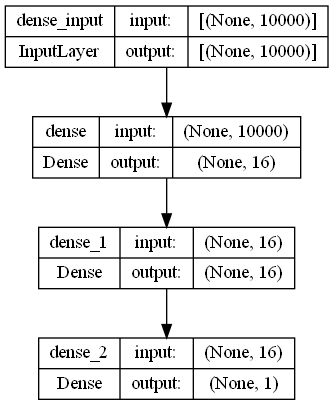

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='imdb_model.png')

### Compiling the model

In [19]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [20]:
# can also pass custom objects
from tensorflow.keras import optimizers

model.compile(
    optimizer=optimizers.RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

C:\Users\asanzete\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [21]:
# and again
from tensorflow.keras import losses, metrics

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    loss=losses.binary_crossentropy,
    metrics=[metrics.binary_accuracy]
)

### Creating a validation set

In [22]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [23]:
# you'll be monitoring loss and accuracy on this validation set instead of using the test set
# 20 epochs - 20 iterations over all samples in the training tensors
# in mini-batches of 512 samples
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val)
)

Epoch 1/20
30/30 [==============================] - 6s 160ms/step - loss: 0.5307 - binary_accuracy: 0.7828 - val_loss: 0.4250 - val_binary_accuracy: 0.8437
Epoch 2/20
30/30 [==============================] - 1s 45ms/step - loss: 0.3333 - binary_accuracy: 0.8976 - val_loss: 0.3207 - val_binary_accuracy: 0.8883
Epoch 3/20
30/30 [==============================] - 1s 41ms/step - loss: 0.2489 - binary_accuracy: 0.9212 - val_loss: 0.2878 - val_binary_accuracy: 0.8893
Epoch 4/20
30/30 [==============================] - 1s 47ms/step - loss: 0.1946 - binary_accuracy: 0.9379 - val_loss: 0.3113 - val_binary_accuracy: 0.8731
Epoch 5/20
30/30 [==============================] - 1s 39ms/step - loss: 0.1608 - binary_accuracy: 0.9472 - val_loss: 0.2738 - val_binary_accuracy: 0.8918
Epoch 6/20
30/30 [==============================] - 1s 28ms/step - loss: 0.1326 - binary_accuracy: 0.9597 - val_loss: 0.2897 - val_binary_accuracy: 0.8853
Epoch 7/20
30/30 [==============================] - 1s 30ms/step - lo

### What happened during training?

In [24]:
# everything that has happened during training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [25]:
import matplotlib.pyplot as plt

In [26]:
acc = history_dict['binary_accuracy']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

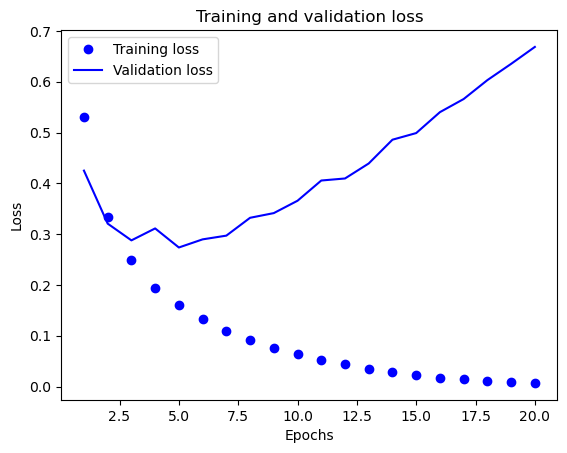

In [29]:
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [30]:
plt.clf() # clears the figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

<Figure size 640x480 with 0 Axes>

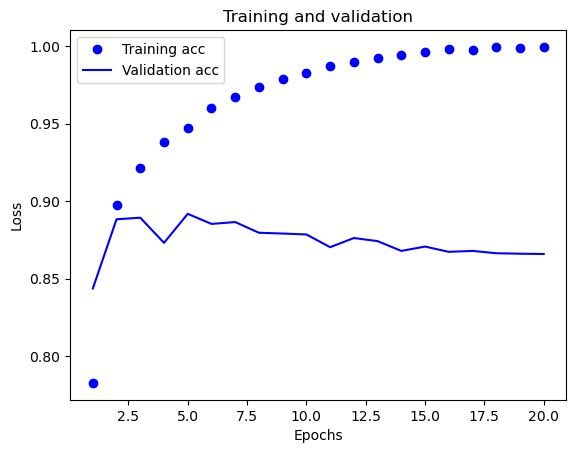

In [32]:
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Seems like these are overfitting... Why does the validation loss increase and accuracy decrease? Training accuracy is almost 1.

Seems to peak at the 5th epoch, so we'll stop training there.

### Retraining this model from scratch

In [33]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/5
49/49 [==============================] - 2s 18ms/step - loss: 0.4794 - accuracy: 0.8213
Epoch 2/5
49/49 [==============================] - 1s 23ms/step - loss: 0.2723 - accuracy: 0.9061
Epoch 3/5
49/49 [==============================] - 1s 15ms/step - loss: 0.2063 - accuracy: 0.9255
Epoch 4/5
49/49 [==============================] - 1s 16ms/step - loss: 0.1710 - accuracy: 0.9394
Epoch 5/5
782/782 [==============================] - 4s 5ms/step - loss: 0.3134 - accuracy: 0.8806


In [34]:
# not bad
results

[0.313429594039917, 0.8805999755859375]

### Predicting on new data

In [35]:
model.predict(x_test)

782/782 [==============================] - 10s 12ms/step


array([[0.20145477],
       [0.9999792 ],
       [0.95985067],
       ...,
       [0.133906  ],
       [0.07463977],
       [0.78446925]], dtype=float32)

## Further experiments
 * What affect does more hidden layers have on the validation and test accuracy?
 * Using more hidden units
 * Try using ``mse`` instead of ``binary_crossentropy``
 * Try using the ``tanh`` activation (an old activation that used to be popular) instead of ``relu``
 
These will more or less convince you that the architecture choices you've made are reasonable.